# Oficial Benchmarck - Nicolas Vandeput - Entendimiento códgio benchmarck
https://www.datasource.ai/en/users/jose-ignacio-ortega-labra/competitions/vn2-inventory-planning-challenge/datathon_detail/notebook/32/show

An 13-week seasonal moving average combined with a forecast-driven policy with a 4 weeks coverage


### Description

This is the official benchmark for VN2. 

It's a very simple model that wasn't optimized (moving average and inventory coverages are arbitrary)

Feel free to use, reuse, and improve :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# set root repo

import subprocess
from pathlib import Path
import os

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

ROOT = Path(repo_root)
os.chdir(ROOT)
print(ROOT)

/Users/joseortega/Documents/GitHub/vn2_challenge


### 0. params

In [3]:
INDEX = ["Store", "Product"]

### Step 1 - Extract data

In [4]:
# path folder data
folder_data = "data/input/raw_start_week0"

# read sales
path_sales = f"{folder_data}/Week 0 - 2024-04-08 - Sales.csv"
sales = pd.read_csv(path_sales).set_index(INDEX)
sales.columns = pd.to_datetime(sales.columns)

# read in_stock
path_in_stock = f"{folder_data}/Week 0 - In Stock.csv"
in_stock = pd.read_csv(path_in_stock).set_index(INDEX)
in_stock.columns = pd.to_datetime(in_stock.columns)

# read state
path_state = f"{folder_data}/Week 0 - 2024-04-08 - Initial State.csv"
state = pd.read_csv(path_state).set_index(INDEX)


In [5]:
sales.head()

2021-04-12  2021-04-19  2021-04-26  2021-05-03  2021-05-10  \
Store Product                                                               
0     126             0.0         0.0         3.0         3.0         0.0   
      182             0.0         0.0         0.0         0.0         0.0   
1     124            13.0         4.0        10.0         5.0         1.0   
2     124             5.0         5.0        12.0        16.0        10.0   
      126             0.0         0.0         6.0         5.0         7.0   

               2021-05-17  2021-05-24  2021-05-31  2021-06-07  2021-06-14  \
Store Product                                                               
0     126             1.0         1.0         0.0         1.0         0.0   
      182             0.0         0.0         0.0         0.0         0.0   
1     124             2.0         3.0         4.0         2.0         1.0   
2     124             8.0        10.0         9.0         7.0        10.0   
      126             4.0         1.0         2.0         6.0         5.0   

               ...  2024-02-05  2024-02-12  2024-02-19  2024-02-26  \
Store Product  ...                                                   
0     126      ...         0.0         2.0         2.0         0.0   
      182      ...         1.0         1.0         0.0         0.0   
1     124      ...         8.0        17.0         6.0        11.0   
2     124      ...         6.0         8.0         8.0        18.0   
      126      ...         2.0         0.0         2.0         5.0   

               2024-03-04  2024-03-11  2024-03-18  2024-03-25  2024-04-01  \
Store Product                                                               
0     126             0.0         0.0         0.0         0.0         2.0   
      182             1.0         1.0         0.0         3.0         1.0   
1     124             8.0        12.0         6.0         7.0         9.0   
2     124            11.0        14.0         3.0        12.0        13.0   
      126             2.0         2.0         4.0         2.0         3.0   

               2024-04-08  
Store Product              
0     126             2.0  
      182             1.0  
1     124             7.0  
2     124             2.0  
      126             2.0  

[5 rows x 157 columns]

In [6]:
sales[~in_stock] = np.nan
#These are shortages, we'll put missing data

#### 1.a Small discovery

In [7]:
sales.head()

2021-04-12  2021-04-19  2021-04-26  2021-05-03  2021-05-10  \
Store Product                                                               
0     126             0.0         0.0         3.0         3.0         0.0   
      182             NaN         NaN         NaN         NaN         NaN   
1     124            13.0         4.0        10.0         5.0         1.0   
2     124             5.0         5.0        12.0        16.0        10.0   
      126             NaN         NaN         6.0         5.0         7.0   

               2021-05-17  2021-05-24  2021-05-31  2021-06-07  2021-06-14  \
Store Product                                                               
0     126             1.0         1.0         0.0         1.0         0.0   
      182             NaN         NaN         NaN         NaN         NaN   
1     124             2.0         3.0         4.0         2.0         1.0   
2     124             8.0        10.0         9.0         7.0        10.0   
      126             4.0         1.0         2.0         6.0         5.0   

               ...  2024-02-05  2024-02-12  2024-02-19  2024-02-26  \
Store Product  ...                                                   
0     126      ...         0.0         2.0         2.0         0.0   
      182      ...         1.0         1.0         0.0         0.0   
1     124      ...         8.0        17.0         6.0        11.0   
2     124      ...         6.0         8.0         8.0        18.0   
      126      ...         2.0         0.0         2.0         5.0   

               2024-03-04  2024-03-11  2024-03-18  2024-03-25  2024-04-01  \
Store Product                                                               
0     126             0.0         0.0         0.0         0.0         2.0   
      182             1.0         1.0         0.0         3.0         1.0   
1     124             8.0        12.0         6.0         7.0         9.0   
2     124            11.0        14.0         3.0        12.0        13.0   
      126             2.0         2.0         4.0         2.0         3.0   

               2024-04-08  
Store Product              
0     126             2.0  
      182             1.0  
1     124             7.0  
2     124             2.0  
      126             2.0  

[5 rows x 157 columns]

In [8]:
sales_first_date = sales.columns[0]
sales_last_date = sales.columns[-1]
print(f"sales_first_date: {sales_first_date}")
print(f"sales_last_date: {sales_last_date}")

sales_first_date: 2021-04-12 00:00:00
sales_last_date: 2024-04-08 00:00:00


In [9]:
in_stock.head()

2021-04-12  2021-04-19  2021-04-26  2021-05-03  2021-05-10  \
Store Product                                                               
0     126            True        True        True        True        True   
      182           False       False       False       False       False   
1     124            True        True        True        True        True   
2     124            True        True        True        True        True   
      126           False       False        True        True        True   

               2021-05-17  2021-05-24  2021-05-31  2021-06-07  2021-06-14  \
Store Product                                                               
0     126            True        True        True        True        True   
      182           False       False       False       False       False   
1     124            True        True        True        True        True   
2     124            True        True        True        True        True   
      126            True        True        True        True        True   

               ...  2024-04-01  2024-04-08  2024-04-15  2024-04-22  \
Store Product  ...                                                   
0     126      ...        True        True        True        True   
      182      ...        True        True        True        True   
1     124      ...        True        True        True        True   
2     124      ...        True        True        True        True   
      126      ...        True        True        True        True   

               2024-04-29  2024-05-06  2024-05-13  2024-05-20  2024-05-27  \
Store Product                                                               
0     126            True        True        True        True        True   
      182            True        True        True        True        True   
1     124            True        True        True        True        True   
2     124            True        True        True        True        True   
      126            True        True        True        True        True   

               2024-06-03  
Store Product              
0     126            True  
      182            True  
1     124            True  
2     124            True  
      126            True  

[5 rows x 165 columns]

In [10]:
in_stock_first_date = in_stock.columns[0]
in_stock_last_date = in_stock.columns[-1]
print(f"in_stock_first_date: {in_stock_first_date}")
print(f"in_stock_last_date: {in_stock_last_date}")

in_stock_first_date: 2021-04-12 00:00:00
in_stock_last_date: 2024-06-03 00:00:00


In [11]:
state.head()

Start Inventory  Sales  Missed Sales  End Inventory  \
Store Product                                                        
0     126                    0      0             0              3   
      182                    0      0             0              1   
1     124                    0      0             0              6   
2     124                    0      0             0              9   
      126                    0      0             0              3   

               In Transit W+1  In Transit W+2  Holding Cost  Shortage Cost  \
Store Product                                                                
0     126                   0               3             0              0   
      182                   0               1             0              0   
1     124                   0               6             0              0   
2     124                   0               7             0              0   
      126                   0               1             0              0   

               Cumulative Holding Cost  Cumulative Shortage Cost  
Store Product                                                     
0     126                            0                         0  
      182                            0                         0  
1     124                            0                         0  
2     124                            0                         0  
      126                            0                         0

In [12]:
state["Start Inventory"].sum()

np.int64(0)

### Step 2 - Make a Seasonal Moving Average Forecast

#### # Step 2a - Compute Seasonal Factors

In [13]:
# We compute *simple* multiplicative weekly seasonal parameters

# para cada FECHA. Calcular el promedio considerando toda la historia
# ojo: es un promedio único, considerando todos los productos
season = sales.mean().rename("Demand").to_frame()
season["Week Number"] = season.index.isocalendar().week

In [14]:
season.head()

,Demand,Week Number
2021-04-12,2.766667,15
2021-04-19,2.438554,16
2021-04-26,3.502326,17
2021-05-03,3.516432,18
2021-05-10,2.827670,19


In [15]:
# cada fecha es una semana
season[season["Week Number"] == 15]

,Demand,Week Number
2021-04-12,2.766667,15
2022-04-11,2.295802,15
2023-04-10,3.008475,15
2024-04-08,2.530885,15


In [16]:
# cada fecha es una semana
season[season["Week Number"] == 15].mean()

Demand         2.650457
Week Number        15.0
dtype: Float64

In [17]:
# LUEGO, se promedio por semana. Como son varios años de datos, se considera un promedio semanal viendo todos los años
season = season.groupby("Week Number").mean()

In [18]:
# revisar cálculo promedio semana considerando todos los años
season[season.index == 15]

,Demand
Week Number,
15,2.650457


In [19]:
#Seasonal parameters (multiplicative) per week
#Normalize to one.
season = season / season.mean() 


# entonces: se tiene la demanda promedio de cada semana (considerando todos los productos). (promedio viendo todos los años)

In [20]:
season.head()

,Demand
Week Number,
1,1.333144
2,0.860937
3,0.808269
4,0.801573
5,0.871259


#### Step 2b - Un-seasonalize Demand

- quitar seasonality de series multiplicativas (divir la venta semanal por el promedio semanal)
- De esta forma, cada valor se normaliza respecto al comportamiento típico del mes.
- Si enero suele ser el doble de junio, al dividir, todos los meses quedan en la misma escala.

In [21]:
# obtener la semana en que ocurre cada venta
sales_weeks = sales.columns.isocalendar().week
sales_weeks

2021-04-12    15
2021-04-19    16
2021-04-26    17
2021-05-03    18
2021-05-10    19
              ..
2024-03-11    11
2024-03-18    12
2024-03-25    13
2024-04-01    14
2024-04-08    15
Name: week, Length: 157, dtype: UInt32

In [22]:
# dividir las ventas semanales por el promedio de venta de cada semana (calculado previamente)
sales_no_season = sales / (season.loc[sales_weeks.values]).values.reshape(-1)

In [23]:
sales_no_season.head(3)

2021-04-12  2021-04-19  2021-04-26  2021-05-03  2021-05-10  \
Store Product                                                               
0     126        0.000000    0.000000    2.712088    2.464356    0.000000   
      182             NaN         NaN         NaN         NaN         NaN   
1     124       16.244433    5.369089    9.040294    4.107259    0.891239   

               2021-05-17  2021-05-24  2021-05-31  2021-06-07  2021-06-14  \
Store Product                                                               
0     126        1.288547    1.194701    0.000000    1.285653    0.000000   
      182             NaN         NaN         NaN         NaN         NaN   
1     124        2.577095    3.584102    4.246314    2.571305    0.942043   

               ...  2024-02-05  2024-02-12  2024-02-19  2024-02-26  \
Store Product  ...                                                   
0     126      ...    0.000000    2.025223    2.443534    0.000000   
      182      ...    1.067899    1.012611    0.000000    0.000000   
1     124      ...    8.543192   17.214393    7.330601   13.261481   

               2024-03-04  2024-03-11  2024-03-18  2024-03-25  2024-04-01  \
Store Product                                                               
0     126        0.000000    0.000000    0.000000    0.000000    2.506615   
      182        1.127364    1.110340    0.000000    3.793839    1.253308   
1     124        9.018910   13.324075    7.359369    8.852292   11.279768   

               2024-04-08  
Store Product              
0     126        2.499144  
      182        1.249572  
1     124        8.747003  

[3 rows x 157 columns]

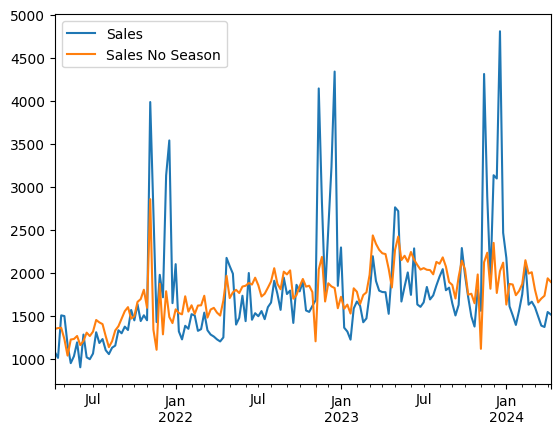

In [24]:
# Let's plot to take a look
ax = sales.sum().plot(label="Sales", legend=True)
sales_no_season.sum().plot(ax=ax, label="Sales No Season", legend=True)
plt.show()

#### Step 2c we make a forecast using a 13 weeks moving average (the number is arbitrary)

In [25]:
# para cada producto, calcular el promedio de las ÚLTIMAS 13 semanas

base_forecast = sales_no_season.iloc[:,-13:].mean(axis=1) 
# That's the unseasonalized moving average of the last 8 weeks
# We need a forecast for 3 weeks.

In [26]:
base_forecast.head()

Store  Product
0      126         0.919149
       182         0.999993
1      124        10.938014
2      124        10.730670
       126         2.213633
dtype: float64

In [27]:
# ejemplo validar, que para cada producto se toma el promedio de las últimas 13 semanas
sales_no_season.loc[(0, 182)][-13:].mean()

np.float64(0.999992962098934)

In [28]:
# calcular cuantas fechas a futuro predecir
# DUDA: por qué se predice los próximos 10 periodos?
f_periods = pd.date_range(start=sales.columns[-1], periods=10, inclusive="neither", freq="W-MON")
f_periods

DatetimeIndex(['2024-04-15', '2024-04-22', '2024-04-29', '2024-05-06',
               '2024-05-13', '2024-05-20', '2024-05-27', '2024-06-03',
               '2024-06-10'],
              dtype='datetime64[ns]', freq='W-MON')

In [29]:
# realizar forecast. Se repite el mismo promedio para los próximo 10 fechas forecasteadas
forecast = pd.DataFrame(data=base_forecast.values.reshape(-1,1).repeat(len(f_periods), axis=1), 
                        columns=f_periods,
                        index=sales.index)

In [30]:
forecast.head()

2024-04-15  2024-04-22  2024-04-29  2024-05-06  2024-05-13  \
Store Product                                                               
0     126        0.919149    0.919149    0.919149    0.919149    0.919149   
      182        0.999993    0.999993    0.999993    0.999993    0.999993   
1     124       10.938014   10.938014   10.938014   10.938014   10.938014   
2     124       10.730670   10.730670   10.730670   10.730670   10.730670   
      126        2.213633    2.213633    2.213633    2.213633    2.213633   

               2024-05-20  2024-05-27  2024-06-03  2024-06-10  
Store Product                                                  
0     126        0.919149    0.919149    0.919149    0.919149  
      182        0.999993    0.999993    0.999993    0.999993  
1     124       10.938014   10.938014   10.938014   10.938014  
2     124       10.730670   10.730670   10.730670   10.730670  
      126        2.213633    2.213633    2.213633    2.213633

In [31]:
# We need to seasonalize this for future forecast.

# forecast sin estacionalidad, se multiplica por el promedio para regresar seasonality
# como "season", tengo una seasonality PROMEDIO PARA CADA SEMANA DEL AÑO, el valor promedio que se repite, ahora tiene seasonality
forecast = forecast * (season.loc[f_periods.isocalendar().week.values]).values.reshape(-1)

In [32]:
forecast.head()

2024-04-15  2024-04-22  2024-04-29  2024-05-06  2024-05-13  \
Store Product                                                               
0     126        0.684771    1.016725    1.118932    1.031316    0.713322   
      182        0.745000    1.106151    1.217348    1.122026    0.776062   
1     124        8.148879   12.099179   13.315465   12.272820    8.488640   
2     124        7.994407   11.869824   13.063054   12.040174    8.327727   
      126        1.649168    2.448629    2.694781    2.483770    1.717929   

               2024-05-20  2024-05-27  2024-06-03  2024-06-10  
Store Product                                                  
0     126        0.769355    0.865832    0.714928    0.975697  
      182        0.837024    0.941987    0.777810    1.061515  
1     124        9.155442   10.303538    8.507751   11.610948  
2     124        8.981889   10.108222    8.346477   11.390848  
      126        1.852876    2.085228    1.721797    2.349821

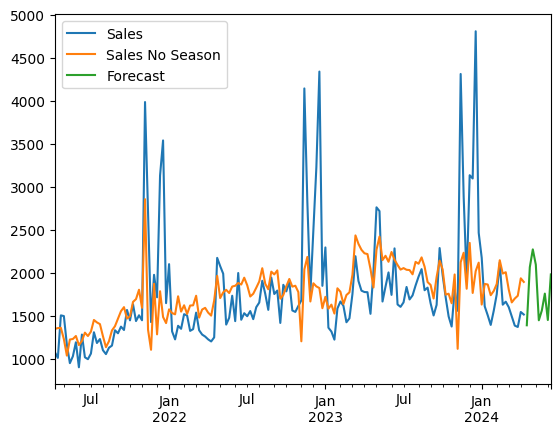

In [33]:
# Let's plot to take a look
ax = sales.sum().plot(label="Sales", legend=True)
sales_no_season.sum().plot(ax=ax, label="Sales No Season", legend=True)
forecast.sum().plot(ax=ax, label="Forecast", legend=True)
plt.legend()
plt.show()

### Step 3 use a forecast-driven order-up-to policy with 4 weeks as coverage.

In [34]:
forecast.iloc[:, :4]

2024-04-15  2024-04-22  2024-04-29  2024-05-06
Store Product                                                
0     126        0.684771    1.016725    1.118932    1.031316
      182        0.745000    1.106151    1.217348    1.122026
1     124        8.148879   12.099179   13.315465   12.272820
2     124        7.994407   11.869824   13.063054   12.040174
      126        1.649168    2.448629    2.694781    2.483770
...                   ...         ...         ...         ...
64    193        0.476827    0.707977    0.779147    0.718138
      238        0.752507    1.117296    1.229614    1.133331
65    126        3.572668    5.304577    5.837826    5.380705
66    124        5.524601    8.202740    9.027331    8.320462
      126        2.100448    3.118675    3.432183    3.163432

[599 rows x 4 columns]

In [35]:
# forecast de la demanda de los próximos 4 horizontes
order_up_to = forecast.iloc[:,:4].sum(axis=1)
order_up_to

Store  Product
0      126         3.851744
       182         4.190525
1      124        45.836342
2      124        44.967460
       126         9.276348
                    ...    
64     193         2.682089
       238         4.232748
65     126        20.095777
66     124        31.075134
       126        11.814739
Length: 599, dtype: float64

In [36]:
# consultar state actual
state.head(4)

Start Inventory  Sales  Missed Sales  End Inventory  \
Store Product                                                        
0     126                    0      0             0              3   
      182                    0      0             0              1   
1     124                    0      0             0              6   
2     124                    0      0             0              9   

               In Transit W+1  In Transit W+2  Holding Cost  Shortage Cost  \
Store Product                                                                
0     126                   0               3             0              0   
      182                   0               1             0              0   
1     124                   0               6             0              0   
2     124                   0               7             0              0   

               Cumulative Holding Cost  Cumulative Shortage Cost  
Store Product                                                     
0     126                            0                         0  
      182                            0                         0  
1     124                            0                         0  
2     124                            0                         0

In [37]:
state[["In Transit W+1", "In Transit W+2", "End Inventory"]].head(4)

In Transit W+1  In Transit W+2  End Inventory
Store Product                                               
0     126                   0               3              3
      182                   0               1              1
1     124                   0               6              6
2     124                   0               7              9

In [38]:
# inventario actual de la red
net_inventory = state[["In Transit W+1", "In Transit W+2", "End Inventory"]].sum(axis=1)
net_inventory

Store  Product
0      126         6
       182         2
1      124        12
2      124        16
       126         4
                  ..
64     193         1
       238         2
65     126         6
66     124        14
       126         4
Length: 599, dtype: int64

In [39]:
# cuanto ordenar (forecast de la demanda predicha - inventario que hay)
order = (order_up_to - net_inventory).clip(lower=0).round(0).astype(int)
order

Store  Product
0      126         0
       182         2
1      124        34
2      124        29
       126         5
                  ..
64     193         2
       238         2
65     126        14
66     124        17
       126         8
Length: 599, dtype: int64

In [40]:
######## otras tablas que están en el input, no utilizada en este discovery

In [41]:
# read master - info de los productos
path_master = f"{folder_data}/Week 0 - Master.csv"
master = pd.read_csv(path_master).set_index(INDEX)
master.head()

ProductGroup  Division  Department  DepartmentGroup  \
Store Product                                                        
0     126            301202      3012          30               11   
      182            440403      4404          44               11   
1     124            240201      2402          24               11   
2     124            240201      2402          24               11   
      126            301202      3012          30               11   

               StoreFormat  Format  
Store Product                       
0     126                1      13  
      182                1      13  
1     124                1      13  
2     124                1      13  
      126                1      13

In [42]:
# read formato submission
path_submission = f"{folder_data}/Week 0 - Submission Template.csv"
submission = pd.read_csv(path_submission).set_index(INDEX)
submission.head()

0
Store Product   
0     126      0
      182      0
1     124      0
2     124      0
      126      0